# Description

This notebook shows some basic usage of CapyMOA and River for a regression using 2 models: Hoeffding Tree regressor and KNN regressor. We measure the time it takes to train/test using the built in functions in both libraries along with the CPU/RAM. One difference between Classification and Regression evaluation in CapyMOA is that the Evaluators are different. Instead of ClassificationEvaluator and ClassificationWindowedEvaluator functions use RegressionEvaluator and RegressionWindowedEvaluator

# Imports 

In [2]:
# CapyMoa
from capymoa.datasets import Fried, FriedTiny
from capymoa.evaluation import prequential_evaluation
from capymoa.regressor import KNNRegressor as CapyKNNR, FIMTDD
from capymoa.evaluation.visualization import plot_windowed_results

# River
from river.evaluate import progressive_val_score, iter_progressive_val_score
from river.metrics import RMSE

from river.tree import  HoeffdingTreeRegressor
from river.neighbors import KNNRegressor as RiverKNNR

# Miscellaneous for tracking
import time, tracemalloc, psutil
import matplotlib.pyplot as plt

# Utils

In [2]:
# Generator to yield (x_dict, y) in river format
def capymoa_to_river_stream(stream):
    feature_names = stream.get_schema().get_numeric_attributes()
    for instance in stream:
        x_dict = dict(zip(feature_names, instance.x))
        y = instance.y_value  # changed for regression
        yield x_dict, y

# Start measurements
def start_measurements():
    tracemalloc.start()
    start_time = time.time()
    cpu_start = psutil.cpu_percent(interval=None)
    return start_time, cpu_start

def end_measurements():
    end_time = time.time()
    cpu_end = psutil.cpu_percent(interval=None)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return end_time, cpu_end, current, peak

# Function to plot the results
def plot_results(results, plot_title):
    # Print results for each learner
    for name, scores in results.items():
        rmse_values = [score['RMSE'].get() for score in scores]
        steps = [score['Step'] for score in scores]  
        plt.plot(steps, rmse_values, label=name)

    plt.xlabel("Instance")
    plt.ylabel("Metric")
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.show()

# CapyMOA

This code evaluates multiple online learning models on a stream provided by the Fried dataset, and prints out performance metrics (accuracy, CPU usage, memory usage) for both learners: FIMTDD (a decision tree classifier) and KNN Regressor.


--- Performance Summary ---
Total Time: 6.96 seconds
CPU Usage: 35.4%
Peak Memory Usage: 0.05 MB


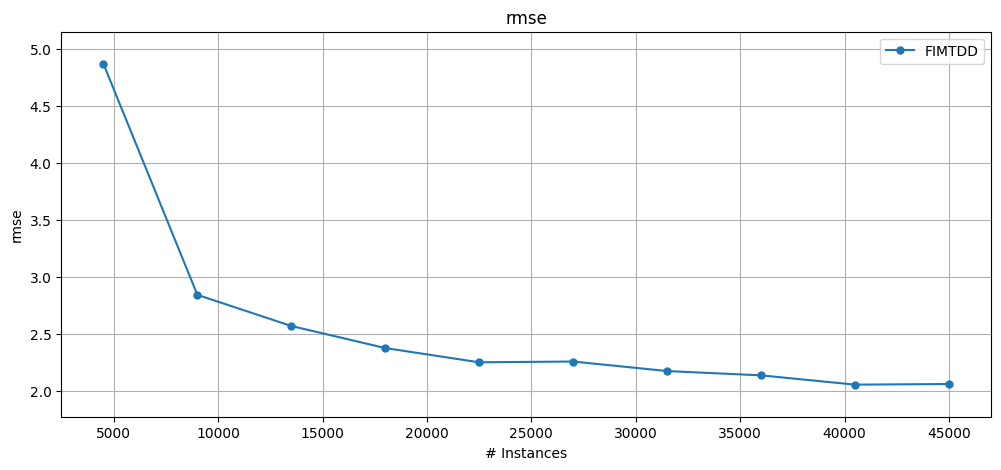

In [ ]:
# Set up the stream for evaluation - Fried is a predefined stream in CapyMoa for regression
stream = Fried()

# Define the learners + an alias (dictionary key)
learners = {
    "HT": FIMTDD(schema=stream.get_schema()),
    "KNN": CapyKNNR(schema=stream.get_schema(), k=2),
}

# Start tracking the time and CPU usage for the evaluation process
start_time, cpu_start = start_measurements()

results = {name: [] for name in learners.keys()}

# Perform prequential evaluation for each learner
# Prequential evaluation measures model performance by alternating between training and testing at each step
for name, learner in learners.items():
    result = prequential_evaluation(stream=stream, learner=learner, window_size=4500)
    results[name] = result

# End time tracking and measure CPU and memory usage
end_time, cpu_end, current, peak = end_measurements()

print(f"\n--- Performance Summary ---")
print(f"Total Time: {end_time - start_time:.2f} seconds")
print(f"CPU Usage: {cpu_end}%")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")

plot_windowed_results(results["HT"],  metric="rmse")

# River

The goal is to assess the predictive accuracy of both learners using the Root Mean Squared Error (RMSE) metric in a progressive validation setup. The evaluation process is performed by sliding a window of data through the learners, which are trained and evaluated every 100 instances. We can notice that there is a significance difference in the amount of time it takes to evaluate the model compared to CapyMOA. In this case, we used the original Fried CapyMOA stream. 

In [ ]:
# Define the learners
learners = {
    "HTR": HoeffdingTreeRegressor(),
    "KNN": RiverKNNR(n_neighbors=3),
}

# Create a prequential evaluation loop for multiple learners
results = { name: [] for name in learners }

start_time, cpu_start = start_measurements()

for name, model in learners.items():
    # Convert CapyMoa stream to River
    stream = capymoa_to_river_stream(Fried())
    
    # Define the evaluation metric as RMSE (Root Mean Squared Error)
    # RMSE is commonly used in regression to measure the accuracy of predictions
    metric = RMSE()

    # Perform progressive validation (sliding window evaluation) on the stream
    # The evaluation step is set to 100, meaning the performance is evaluated every 100 instances
    steps_score = list(iter_progressive_val_score(dataset=stream, model=model, metric=metric, step=100))
    results[name] = steps_score

end_time, cpu_end, current, peak = end_measurements()

print(f"\n--- Performance Summary ---")
print(f"Total Time: {(end_time - start_time) / 60 :.2f} minutes")
print(f"CPU Usage: {cpu_end}%")
print(f"Peak Memory Usage: {peak / 10**6:.2f} MB")


--- Performance Summary ---
Total Time: 122.18 minutes
CPU Usage: 38.4%
Peak Memory Usage: 34.98 MB


CapyMOA shows a much (much) faster execution time of just 6.96 seconds, with relatively low computational resource usage (35.4% CPU and 0.05 MB peak memory usage). This suggests that CapyMOA is highly efficient for streaming regression tasks (in addition to classificationt tasks). 
In contrast, River demonstrates a much higher execution time of 122.18 minutes, with significantly higher memory usage (34.98 MB) and a slightly higher CPU usage of 38.4%. 